<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/useful/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install exchange_calendars
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import numpy as np
import requests
import datetime
import exchange_calendars as ecals # 개장일만
from io import StringIO
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import random
import seaborn as sns

In [32]:
XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [33]:
class StockAnalyzer():
  def __init__(self, code='005930',period=365, sample_num=500, variables=[]):
    self.code = code
    self.period = period
    self.sample_num = sample_num

    self.start, self.today = self.get_date()
    self.df = self.get_df()
    self.mean, self.std = self.get_stats()

  def get_date(self):
    today = datetime.date.today().strftime('%Y%m%d')
    start = (datetime.date.today() - datetime.timedelta(days=self.period)).strftime('%Y%m%d')

    if XKRX.is_session(today) == False:
      today = XKRX.previous_open(today).strftime('%Y%m%d')
    if XKRX.is_session(start) == False:
      start = XKRX.next_open(start).strftime('%Y%m%d')
    return start, today
  
  def get_df(self):
    df = fdr.DataReader(self.code, self.start, self.today)
    df['Change'] += 1
    return df
  
  def get_stats(self):
    return self.df['Change'].mean(), self.df['Change'].std()

  # type: monte, bootstrap
  def get_simulation(self, sim_type='monte'):
    if sim_type == 'monte':      
      dates = XKRX.sessions_window(self.today, 249)

      close_li = [pd.DataFrame({'Change':[random.gauss(self.mean, self.std) for i in dates]}, index=dates) for x in range(self.sample_num)]
      close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * self.df['Close'][-1], close_li))

      fig = plt.figure(figsize=(16, 8))
      ax = plt.subplot(111)
      colors = list(sns.color_palette("hls", self.sample_num).as_hex())

      for i, j in enumerate(close_li):
        ax.plot(j['Close'], color=colors[i]) #, label=i+1)

      plt.show()


In [34]:
sa = StockAnalyzer()

DatetimeIndex(['2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-24',
               ...
               '2024-03-29', '2024-04-01', '2024-04-02', '2024-04-03',
               '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09',
               '2024-04-10', '2024-04-11'],
              dtype='datetime64[ns]', length=249, freq='C')


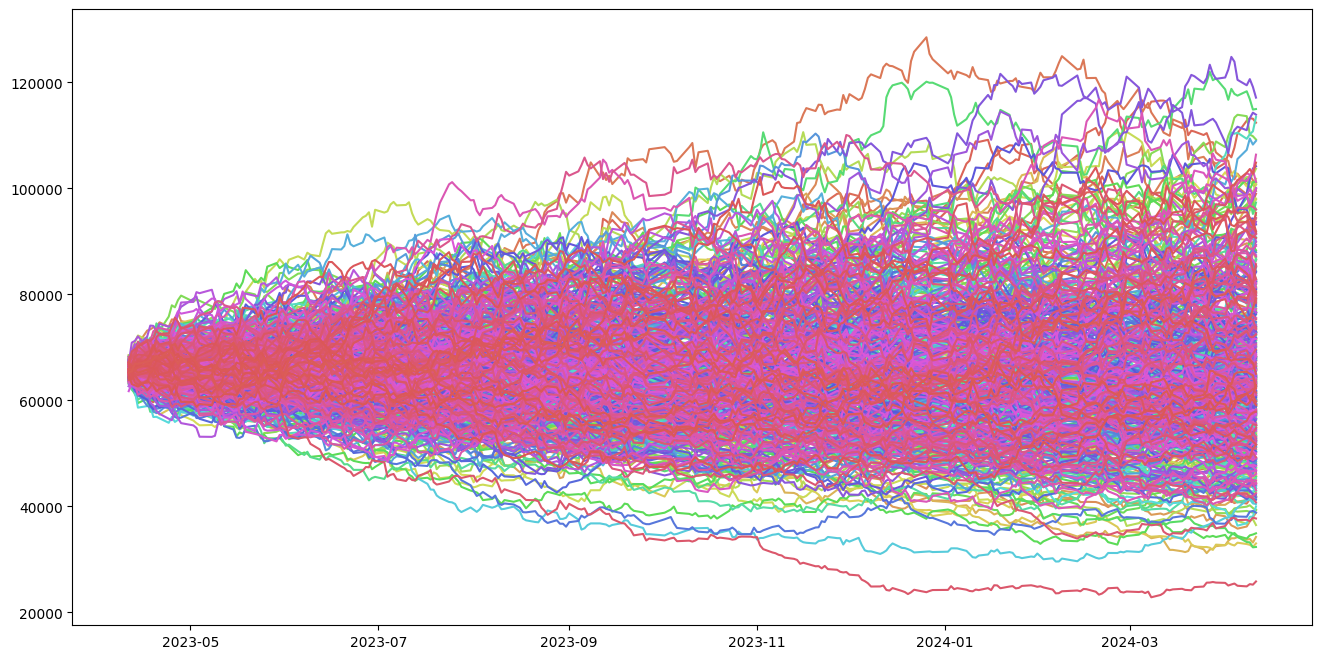

In [35]:
sa.get_simulation()

Monte Carlo Simulation

In [69]:
from datetime import datetime, date
import random
import math

m = df['Change'].mean()
std = df['Change'].std()

dates = df[df.index > start].index[:period]

In [70]:
dates

DatetimeIndex(['2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15',
               '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21',
               '2022-04-22', '2022-04-25',
               ...
               '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-03',
               '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-07',
               '2023-04-10', '2023-04-11'],
              dtype='datetime64[ns]', name='Date', length=249, freq=None)

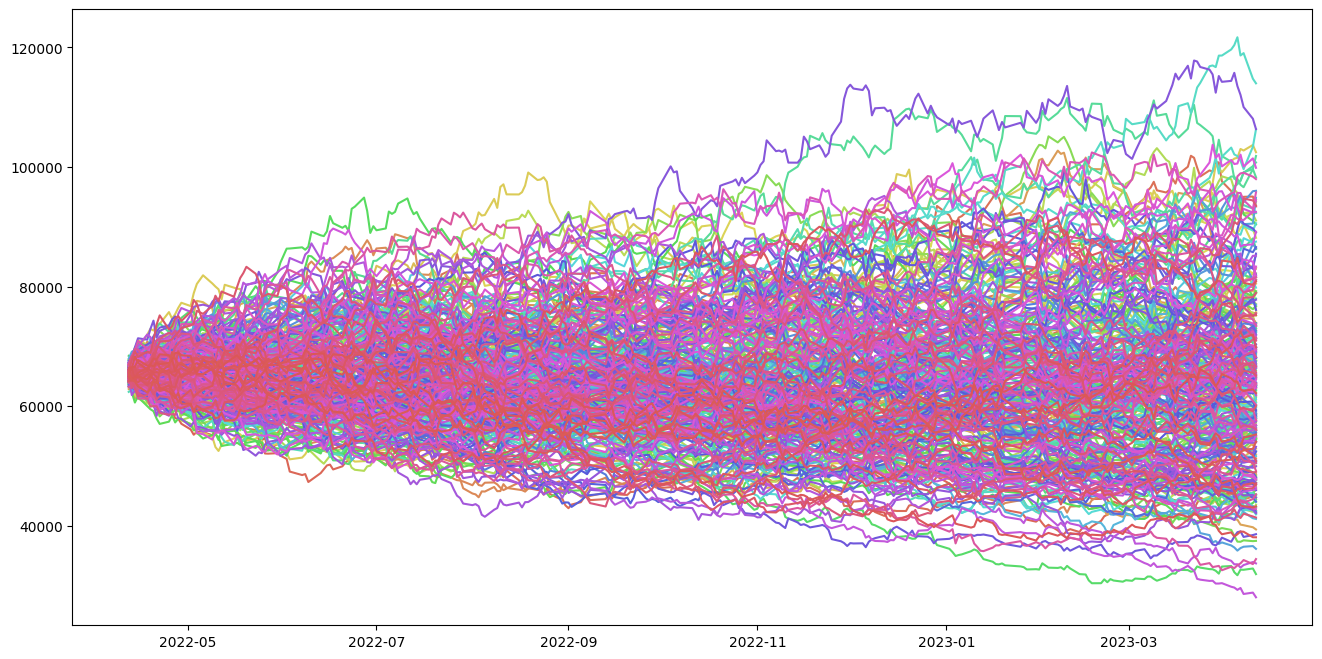

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

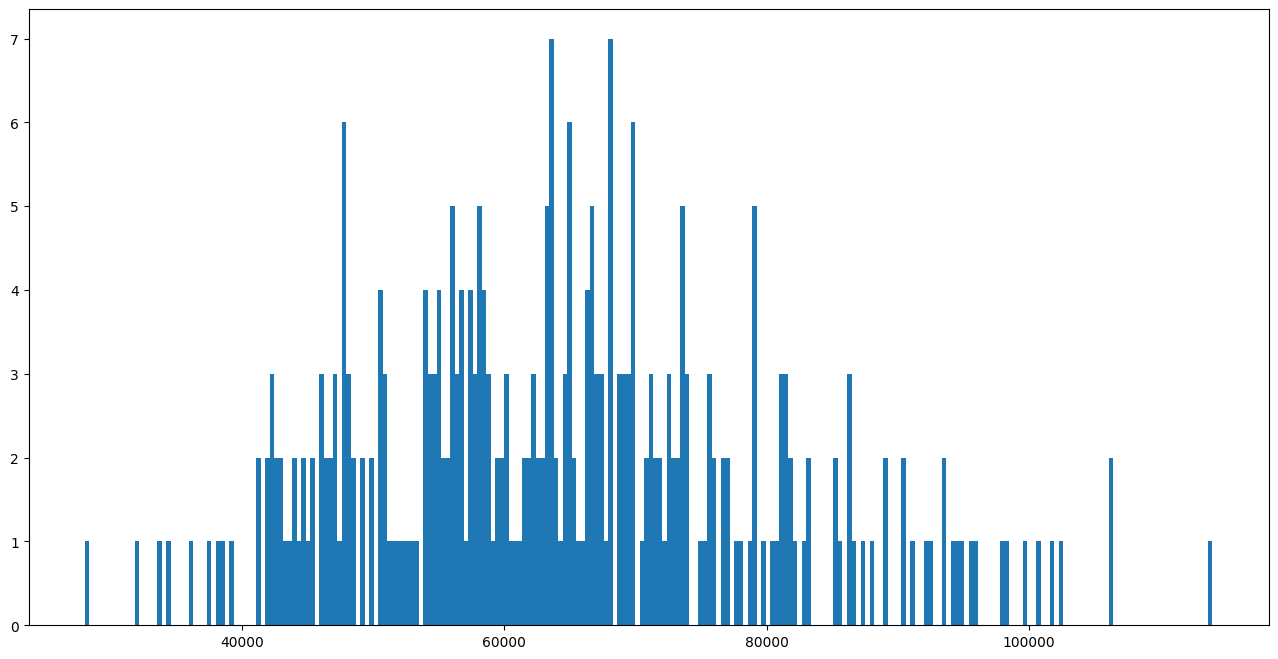

In [73]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [ ]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
monte_mean = np.mean([round(x.iloc[-1].values[0],0) for x in close_li])
print('Mean: ', monte_mean)

# 중앙
monte_median = np.median([round(x.iloc[-1].values[0],0) for x in close_li])
print('Median: ', monte_median)

95% Min:  68290
95% Max:  69494
Mean:  68891.901
Median:  68110.0


In [ ]:
monte_date = close_li[0].index[-1]

Circular Block Bootstrap

In [ ]:
block = round(periods ** (1/2))
data = list(test_df['Change'][-periods:].values)
ccb = [(data+data[:block])[x:block+x] for x in range(len(data))]

In [ ]:
import random

change = [j for sub in random.sample(ccb, int(periods/block)) for j in sub]

periods = len(change)
dates = df[df.index > end_date].index[:periods]
close_li = [pd.DataFrame({'Change':[j for sub in random.sample(ccb, int(periods/block)) for j in sub]}, index=dates) for x in range(sample_num)]
close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * test_df['Close'][-1], close_li))

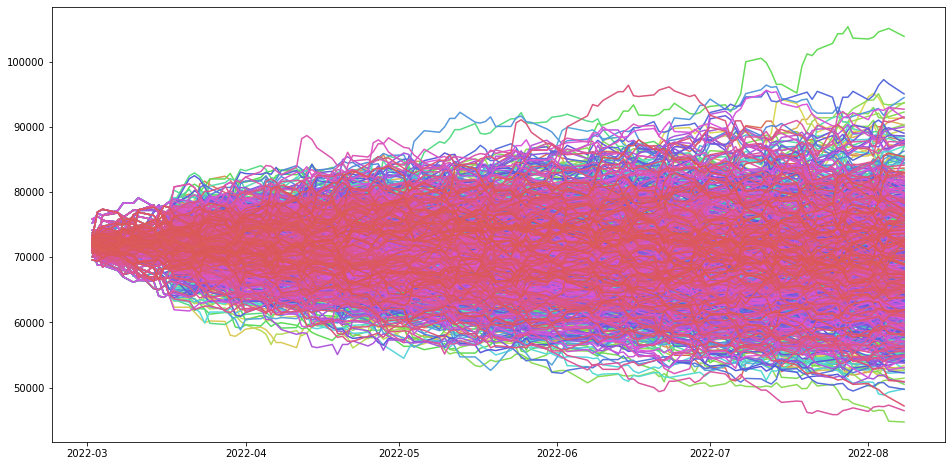

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

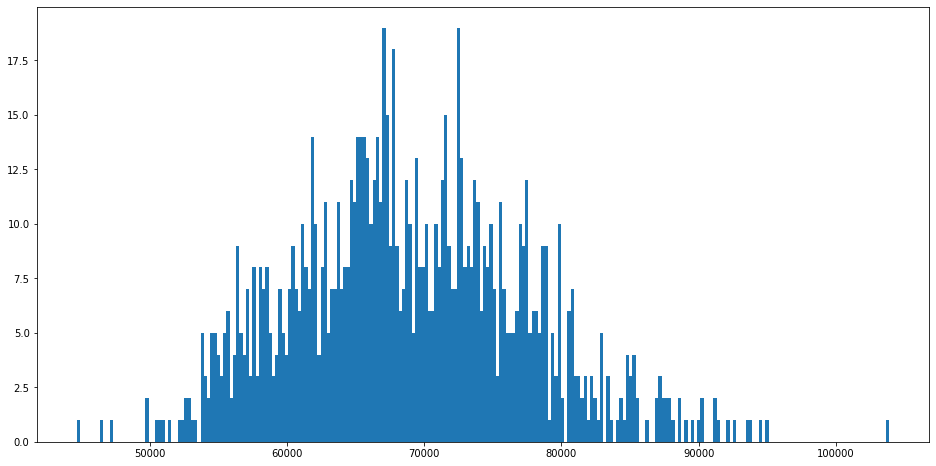

In [ ]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [ ]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
ccb_mean =  np.mean([round(x.iloc[-1].values[0],0) for x in close_li])
print('Mean: ', ccb_mean)

# 중앙
ccb_median = np.median([round(x.iloc[-1].values[0],0) for x in close_li])
print('Median: ', ccb_median)

95% Min:  68367
95% Max:  69416
Mean:  68891.29
Median:  68122.0


In [ ]:
ccb_date = close_li[0].index[-1]

In [ ]:
monte_date

Timestamp('2022-08-23 00:00:00')

In [ ]:
ccb_date

Timestamp('2022-08-08 00:00:00')

In [ ]:
print('Min: ', min(monte_median, ccb_median))
print('Max: ', max(monte_median, ccb_median))

Min:  68110.0
Max:  68122.0
